# Simulations TVA - Budget 2025 : Chapitre socio-fiscal

In [1]:
import numpy as np
import pandas as pd
import os
import csv
import ast
import seaborn as sns
from matplotlib import pyplot as plt
import wquantiles

from wquantiles import quantile
from openfisca_survey_manager.utils import asof

from openfisca_france_indirect_taxation import FranceIndirectTaxationTaxBenefitSystem
from openfisca_france_indirect_taxation.surveys import SurveyScenario
from openfisca_france_indirect_taxation.examples.utils_example import (
    dataframe_by_group,
    df_weighted_average_grouped)
from openfisca_france_indirect_taxation.build_survey_data.utils import weighted_sum
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.new_calage_bdf_cn import new_get_inflators_by_year
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import weighted_quantiles
from openfisca_france_indirect_taxation.utils import assets_directory, get_input_data_frame

In [2]:
simulated_variables = ['depenses_tva_taux_plein',
'depenses_tva_taux_intermediaire',
'depenses_tva_taux_reduit',
'depenses_tva_taux_super_reduit',
'depenses_tva_exonere',
'depenses_totales',
'depenses_tot',
 'niveau_de_vie',
 'niveau_vie_decile',
 'ocde10',
 'pondmen',
 'nactifs',
 'npers']

In [3]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Reform_TVA_budget_2025 import augmente_tous_les_taux

In [4]:
year = 2024
data_year = 2017
tax_benefit_system = FranceIndirectTaxationTaxBenefitSystem()
inflators_by_year = new_get_inflators_by_year(rebuild = False, year_range = range(2017, 2025), data_year = data_year)
inflation_kwargs = dict(inflator_by_variable = inflators_by_year[year])

In [5]:
survey_scenario = SurveyScenario.create(
    inflation_kwargs =  inflation_kwargs,
    baseline_tax_benefit_system = tax_benefit_system,
    reform = augmente_tous_les_taux,
    year = year,
    data_year = data_year
    )

In [6]:
baseline_menage = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = True, period = 2024)['menage']
reform_menage   = survey_scenario.create_data_frame_by_entity(simulated_variables, filter_by = 'rev_disponible > 0', use_baseline = False, period = 2024)['menage']

In [7]:
difference_menage = pd.DataFrame()
difference_menage['depenses_totales'] = baseline_menage['depenses_totales'] - reform_menage['depenses_totales']
difference_menage[['depenses_tot','niveau_de_vie','niveau_vie_decile','ocde10','pondmen','nactifs','npers']] = baseline_menage[['depenses_tot','niveau_de_vie','niveau_vie_decile','ocde10','pondmen','nactifs','npers']]
for taux in ['plein','intermediaire', 'reduit', 'super_reduit']:
    difference_menage['depenses_tva_taux_{}'.format(taux)] = baseline_menage['depenses_tva_taux_{}'.format(taux)] - reform_menage['depenses_tva_taux_{}'.format(taux)] 
difference_menage['actifs'] = (difference_menage['nactifs'] > 1)

In [8]:
difference_menage['cinquantieme_niveau_vie'] = weighted_quantiles(difference_menage['niveau_de_vie'], labels = np.arange(1,51), weights = difference_menage['pondmen'], return_quantiles=False)

In [9]:
perc_2 = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] == 1, :]
list_var = perc_2.columns.tolist()
list_var.remove('pondmen')
average_perc_2 = df_weighted_average_grouped(perc_2,'actifs',list_var)
average_perc_2['pondmen'] = perc_2.groupby(by = 'actifs')['pondmen'].sum()
average_perc_2['npers'] = average_perc_2['npers'].round()
average_perc_2['actifs'] = average_perc_2['actifs'].astype('bool')

difference_menage = difference_menage.loc[difference_menage['cinquantieme_niveau_vie'] > 1] 
difference_menage = pd.concat([difference_menage,average_perc_2])
difference_menage = difference_menage.reset_index().drop('index', axis = 1) 

### Passage base ménages -> base individuelle

In [10]:
difference_indiv = difference_menage.loc[difference_menage.index.repeat(difference_menage['npers'])]
difference_indiv['quantile_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,11), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['quantile_indiv_niveau_vie'] = difference_indiv['quantile_indiv_niveau_vie'].astype(int)

In [11]:
difference_menage['npers'].sum(), len(difference_indiv)

(28124.0, 28124)

### Les effets d'une hausse de TVA par décile de niveau de vie

In [12]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
difference_indiv['depenses_totales_par_uc'] = difference_indiv['depenses_totales'] / difference_indiv['ocde10']
for taux in liste_taux:
   difference_indiv['depenses_par_uc_tva_taux_{}'.format(taux)] = difference_indiv['depenses_tva_taux_{}'.format(taux)] / difference_indiv['ocde10']

difference_by_decile = df_weighted_average_grouped(dataframe = difference_indiv, 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_totales_par_uc','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
for taux in liste_taux:
   difference_by_decile['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile['niveau_de_vie'] * 100
difference_by_decile['Taux_effort_total'] = difference_by_decile['depenses_totales_par_uc'] / difference_by_decile['niveau_de_vie'] * 100

In [13]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import stacked_bar_plot

In [14]:
difference_by_decile

,depenses_totales_par_uc,niveau_de_vie,depenses_par_uc_tva_taux_plein,depenses_par_uc_tva_taux_intermediaire,depenses_par_uc_tva_taux_reduit,depenses_par_uc_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
quantile_indiv_niveau_vie,,,,,,,,,,,
1,-119.359006,12722.739418,-64.091691,-17.981518,-35.787798,-1.498034,-0.503757,-0.141334,-0.281290,-0.011774,-0.938155
2,-135.162583,19735.870687,-72.993115,-18.880045,-40.923775,-2.365646,-0.369850,-0.095664,-0.207357,-0.011987,-0.684857
3,-148.666386,23909.334232,-82.166295,-21.931667,-42.362355,-2.206127,-0.343658,-0.091728,-0.177179,-0.009227,-0.621792
4,-170.207135,27638.286547,-92.392451,-25.048682,-50.070628,-2.695369,-0.334292,-0.090630,-0.181164,-0.009752,-0.615838
5,-190.012566,31160.615839,-101.572100,-33.876645,-51.261724,-3.302002,-0.325963,-0.108716,-0.164508,-0.010597,-0.609784
6,-221.171658,34832.914406,-108.671413,-52.521726,-56.514277,-3.464324,-0.311979,-0.150782,-0.162244,-0.009946,-0.634950
7,-216.180531,38862.703620,-116.533033,-36.860628,-59.591735,-3.195098,-0.299858,-0.094848,-0.153339,-0.008222,-0.556267
8,-255.150093,44124.278452,-132.236693,-48.794980,-70.152257,-3.966258,-0.299691,-0.110585,-0.158988,-0.008989,-0.578253
9,-278.161743,52176.480431,-143.205322,-56.381336,-73.429900,-5.145139,-0.274463,-0.108059,-0.140734,-0.009861,-0.533117


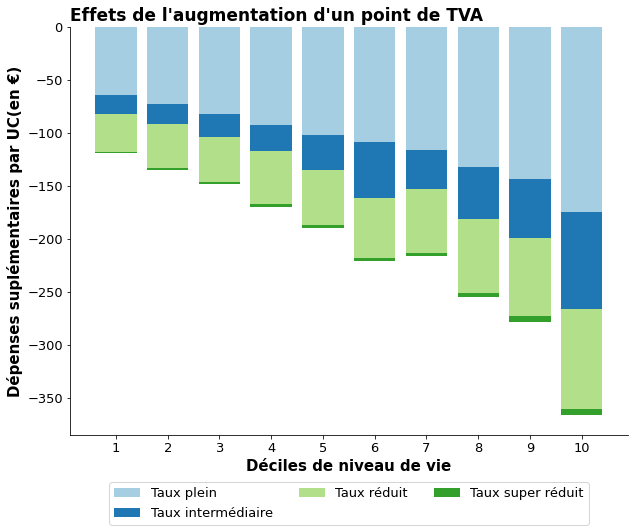

In [15]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Dépenses suplémentaires par UC(en €)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Effet_net_augmentation_TVA.pdf')

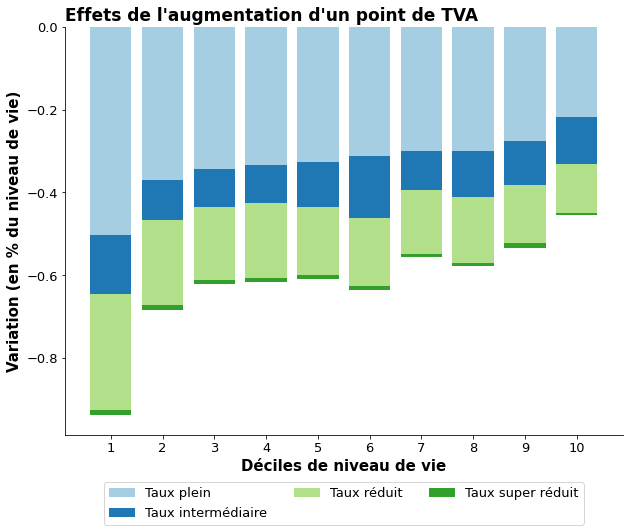

In [16]:
stacked_bar_plot(difference_by_decile, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort.pdf')

#### Décomposition actifs / inactifs

In [17]:
difference_by_decile_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 1], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_totales_par_uc','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
for taux in liste_taux:
   difference_by_decile_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_actifs['niveau_de_vie'] * 100
difference_by_decile_actifs['Taux_effort_total'] = difference_by_decile_actifs['depenses_totales_par_uc'] / difference_by_decile_actifs['niveau_de_vie'] * 100



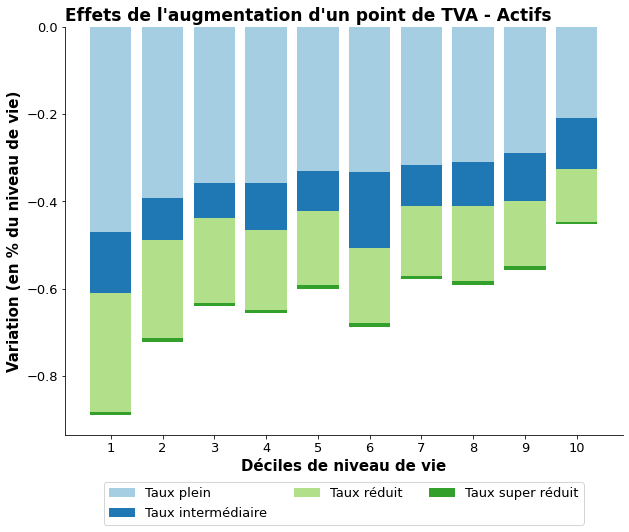

In [18]:
stacked_bar_plot(difference_by_decile_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Actifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_actifs_only.pdf')

In [19]:
difference_by_decile_not_actifs = df_weighted_average_grouped(dataframe = difference_indiv.loc[difference_indiv['actifs'] == 0], 
                                                   groupe = 'quantile_indiv_niveau_vie', 
                                                   varlist = ['depenses_totales_par_uc','niveau_de_vie'] +
                                                   ['depenses_par_uc_tva_taux_{}'.format(taux) for taux in liste_taux],
                                                    )
for taux in liste_taux:
   difference_by_decile_not_actifs['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_decile_not_actifs['depenses_par_uc_tva_taux_{}'.format(taux)] / difference_by_decile_not_actifs['niveau_de_vie'] * 100
difference_by_decile_not_actifs['Taux_effort_total'] = difference_by_decile_not_actifs['depenses_totales_par_uc'] / difference_by_decile_not_actifs['niveau_de_vie'] * 100

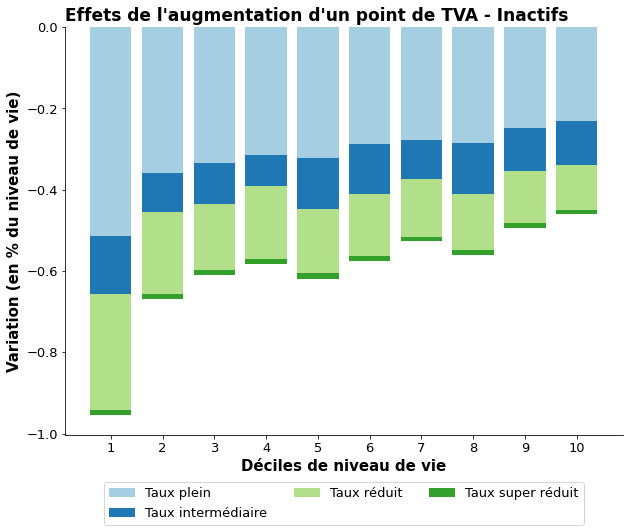

In [20]:
stacked_bar_plot(difference_by_decile_not_actifs, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA - Inactifs",
                 xlabel = 'Déciles de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = True,
                 outfile = 'Taux_effort_not_actifs.pdf')

In [21]:
from openfisca_france_indirect_taxation.projects.TVA_Herve_IPP.Utils import double_stacked_bar_plot

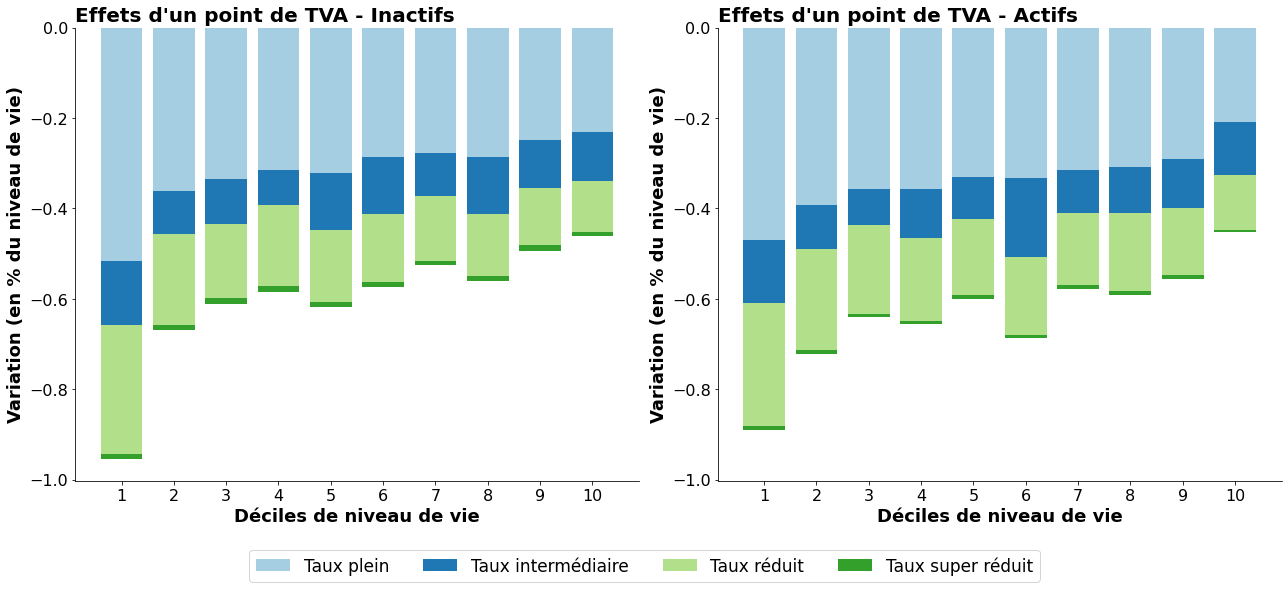

In [22]:
double_stacked_bar_plot(difference_by_decile_not_actifs,
                        difference_by_decile_actifs, 
                        variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                        labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                        title1 = "Effets d'un point de TVA - Inactifs",
                        title2 = "Effets d'un point de TVA - Actifs",
                        xlabel = 'Déciles de niveau de vie' ,
                        ylabel = 'Variation (en % du niveau de vie)',
                        colors = list(sns.color_palette("Paired")),
                        savefig = True,
                        outfile = 'Taux_effort_actifs_not_actifs.pdf')

In [23]:
output_data_path = 'C:/Users/veve1/OneDrive/Documents/IPP/Budget 2026 TVA/Figures/Data/'

In [27]:
output_data_path = 'C:/Users/veve1/OneDrive/Documents/IPP/Budget 2026 TVA/Figures/Data/'
columns_list = ['Taux_effort_total'] + ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux]
to_graph_all = difference_by_decile[columns_list] 
to_graph_all.to_csv(os.path.join(output_data_path,'to_graph_all.csv'), sep = ',', index = True)

# Actifs en emploi uniquement
to_graph_actifs_only = difference_by_decile_actifs[columns_list]
to_graph_actifs_only.to_csv(os.path.join(output_data_path,'to_graph_actifs_only.csv'), sep = ',', index = True)

# Inactifs sans emploi
to_graph_not_actifs = difference_by_decile_not_actifs[columns_list]
to_graph_not_actifs.to_csv(os.path.join(output_data_path,'to_graph_not_actifs.csv'), sep = ',', index = True)

### Analyse par vingtième de niveau de vie

In [25]:
difference_indiv['vingtieme_indiv_niveau_vie'] = weighted_quantiles(difference_indiv['niveau_de_vie'], labels = np.arange(1,21), weights = difference_indiv['pondmen'], return_quantiles=False)
difference_indiv['vingtieme_indiv_niveau_vie'] = difference_indiv['vingtieme_indiv_niveau_vie'].astype(int)

In [26]:
liste_taux = ['plein','intermediaire', 'reduit', 'super_reduit']
difference_by_vingtieme = df_weighted_average_grouped(dataframe = difference_indiv, 
                                                   groupe = 'vingtieme_indiv_niveau_vie', 
                                                   varlist = ['depenses_tot','depenses_totales','niveau_de_vie','rev_disponible','ocde10'] +
                                                   ['depenses_tva_taux_{}'.format(taux) for taux in liste_taux]
                                                    )
for taux in liste_taux:
   difference_by_vingtieme['Taux_effort_tva_taux_{}'.format(taux)] = difference_by_vingtieme['depenses_tva_taux_{}'.format(taux)] / difference_by_vingtieme['rev_disponible'] * 100
difference_by_vingtieme['Taux_effort_total'] = difference_by_vingtieme['depenses_totales'] / difference_by_vingtieme['rev_disponible'] * 100

KeyError: 'rev_disponible'

In [ ]:
difference_by_vingtieme

,depenses_tot,depenses_totales,niveau_de_vie,rev_disponible,ocde10,depenses_tva_taux_plein,depenses_tva_taux_intermediaire,depenses_tva_taux_reduit,depenses_tva_taux_super_reduit,Taux_effort_tva_taux_plein,Taux_effort_tva_taux_intermediaire,Taux_effort_tva_taux_reduit,Taux_effort_tva_taux_super_reduit,Taux_effort_total
vingtieme_indiv_niveau_vie,,,,,,,,,,,,,,
1,30447.749859,-205.645707,9714.865774,17951.582571,1.737600,-105.458285,-31.230198,-66.707550,-2.249701,-0.587460,-0.173969,-0.371597,-0.012532,-1.145558
2,33554.970420,-229.568854,15727.373460,31543.518472,2.002623,-126.195949,-29.690278,-70.827707,-2.854763,-0.400069,-0.094125,-0.224540,-0.009050,-0.727785
3,37692.613209,-264.654903,18534.013447,36968.648502,1.993161,-144.520686,-33.120223,-82.766804,-4.247041,-0.390928,-0.089590,-0.223884,-0.011488,-0.715890
4,36748.903747,-253.020016,20937.682493,39341.852948,1.876755,-136.174979,-34.055576,-78.704871,-4.084527,-0.346133,-0.086563,-0.200054,-0.010382,-0.643132
5,38835.764824,-262.765215,22896.662390,42159.993242,1.840678,-145.971577,-33.058312,-80.289254,-3.446051,-0.346232,-0.078412,-0.190439,-0.008174,-0.623257
6,41540.282636,-285.751925,24924.124212,45756.181241,1.834260,-153.983350,-43.151025,-84.699318,-3.918326,-0.336530,-0.094306,-0.185110,-0.008563,-0.624510
7,46340.903982,-325.240456,26765.196399,49575.521380,1.852274,-173.481527,-50.470127,-96.297101,-4.991903,-0.349934,-0.101805,-0.194243,-0.010069,-0.656050
8,44348.923956,-303.891393,28511.509437,51325.293325,1.798922,-167.267381,-39.958867,-92.635403,-4.029853,-0.325897,-0.077854,-0.180487,-0.007852,-0.592089
9,47155.404315,-330.774472,30267.822047,54319.179598,1.794109,-173.304981,-60.317138,-92.280993,-4.871363,-0.319049,-0.111042,-0.169887,-0.008968,-0.608946


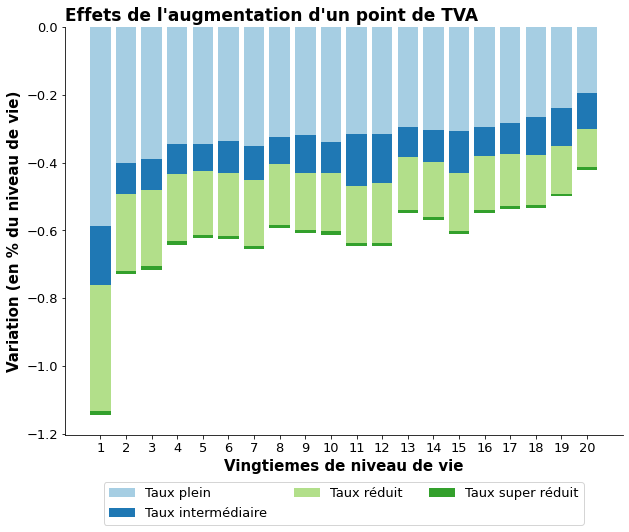

In [ ]:
stacked_bar_plot(difference_by_vingtieme, 
                 variables = ['Taux_effort_tva_taux_{}'.format(taux) for taux in liste_taux],
                 labels = ['Taux plein','Taux intermédiaire','Taux réduit','Taux super réduit'],
                 title = "Effets de l'augmentation d'un point de TVA",
                 xlabel = 'Vingtiemes de niveau de vie' ,
                 ylabel ='Variation (en % du niveau de vie)',
                 colors = list(sns.color_palette("Paired")),
                 savefig = False,
                 outfile = '')

In [4]:
from openfisca_france_indirect_taxation.variables.base import get_legislation_data_frames

In [5]:
categories_fiscales_data_frame, codes_coicop_data_frame = get_legislation_data_frames()

In [9]:
categories_fiscales_data_frame.loc[categories_fiscales_data_frame['categorie_fiscale'] == 'tva_taux_super_reduit']

,code_bdf,categorie_fiscale,start,stop,label,Label,formatted_code_bdf,code_coicop
146,c06111,tva_taux_super_reduit,1994,2024,Produits pharmaceutiques à ingurgiter et trait...,Produits pharmaceutiques à ingurgiter et trait...,06.1.1.1,06.1.1.1
212,c09521,tva_taux_super_reduit,1994,2024,Journaux et périodiques yc par abonnement,Journaux et périodiques,09.5.2.1,09.7.2.1


In [7]:
from openfisca_france_indirect_taxation.build_survey_data.matching_bdf_enl.step_4_1_clean_data import prepare_bdf_enl_matching_data

In [18]:
data_enl, data_bdf = load_data_bdf_enl(2017)

In [10]:
from openfisca_survey_manager.survey_collections import SurveyCollection

In [11]:
year_bdf = 2017
openfisca_survey_collection = SurveyCollection.load(collection = 'openfisca_indirect_taxation')
openfisca_survey = openfisca_survey_collection.get_survey('openfisca_indirect_taxation_data_{}'.format(year_bdf))
input_bdf = openfisca_survey.get_values(table = 'input')
input_bdf.reset_index(inplace = True)

In [15]:
from openfisca_survey_manager.survey_collections import SurveyCollection
from openfisca_survey_manager import default_config_files_directory as config_files_directory


def load_data_bdf_enl(year_data):

    enl_provisoire = False

    # Load ENL data :
    year_enl = 2013
    enl_survey_collection = SurveyCollection.load(
        collection = 'enquete_logement', config_files_directory = config_files_directory
        )
    survey_enl = enl_survey_collection.get_survey('enquete_logement_{}'.format(year_enl))
    input_enl = survey_enl.get_values(table = 'menlog_diff')
    input_enl_indiv = survey_enl.get_values(table = 'indiv_diff')

    # Load BdF data :
    year_bdf = year_data
    openfisca_survey_collection = SurveyCollection.load(collection = 'openfisca_indirect_taxation')
    openfisca_survey = openfisca_survey_collection.get_survey('openfisca_indirect_taxation_data_{}'.format(year_bdf))
    input_bdf = openfisca_survey.get_values(table = 'input')
    input_bdf.reset_index(inplace = True)

    # Create variable for total spending
    liste_variables = input_bdf.columns.tolist()
    postes_agreges = ['poste_{}'.format(index) for index in
        ["0{}".format(i) for i in range(1, 10)] + ["10", "11", "12"]
        ]
    input_bdf['depenses_tot'] = 0
    for element in liste_variables:
        for poste in postes_agreges:
            if element[:8] == poste:
                input_bdf['depenses_tot'] += input_bdf[element]

    # Set variables :
    variables_menages_bdf = [
        'agepr',            # âge de la pr
        'aidlog1',          # aides au logement
        'aidlog2',
        'aise',             # à l'aise avec le budget
        'ancons',
        'cataeu',           # type de commune
        'chaufp',
        'cs42pr',           # catégorie socio-pro de lpr
        'cs42cj',           # catégorie socio-pro du conjoint
        'decuc',            
        'depenses_tot',
        'dip14cj',          # diplômes conjoint
        'dip14pr',          # diplômes de la pr
        # 'h_trans1',
        'htl',              # type de logement
        'ident_men',
        'identifiant_menage',
        'mall1',
        'mall2',
        'mchof',
        'mchof_d',
        'mfac_eau1_d',
        # 'mfac_eg1_d',
        'mloy_d',
        # 'mode_trans1', depindiv
        'nbh1',
        'nbphab',
        'nactifs',
        'nenfants',
        'npers',
        'ocde10',           # nb unités de conso
        'pondmen',
        'poste_04_5_0_0',   # Facture électricité + gaz (non dissociables)
        'poste_04_5_1_1',   # Facture d'électricité
        'poste_04_5_2_1',   # Facture de gaz
        'poste_04_5_2_2',   # Achats de butane, propane (gaz liquéfié)
        'poste_04_5_3_1',   # Combustibles liquides (fuel, mazout, pétrole)
        'poste_04_5_4_1',   # Combustibles solides (bois, harbon de bois, charbon, coke)
        'poste_04_5_5_1',   # Chauffage urbain
        'poste_04_5_5_2',   # Glace
        # 'poste_07_2_2_1_1',
        'revtot',           # revenu total
        'situapr',          # situation pro
        'situacj',
        'stalog',
        'surfhab_d',        # surface habitable
        'tau',
        'tuu',
        'typmen',
        'zeat',             # zone climatique
        ]

    variables_menages_enl = [
        'aba',
        'amr',
        'cataeu2010',
        'cceml',
        'coml',
        'coml11',
        'coml12',
        'coml13',
        'coml2',
        'coml3',
        'coml41',
        'coml42',
        'dom',
        'enfhod',
        'kusa_5',
        'gchauf_1',     # raisons du froid dans le logement
        'gchauf_2',
        'gchauf_3',
        'gchauf_4',
        'gchauf_5',
        'gchauf_6',
        'gchauf_7',
        'gchauf_n',     # nombre de raisons du froid
        'gchaufs_1',    # solutions contre le froid
        'gchaufs_2',
        'gchaufs_3',
        'gchaufs_4',
        'gchaufs_5',
        'gmoy1',       # moyen utilisé trajet travail
        'gmur',        # isolation thermique murs
        'gtoit2',      # isolation thermique toit
        'gtt1',        # durée trajet domicile-travail
        'gvit1',       # majorité double vitrage
        'gvit1b',      # fenêtres laissent passer l'air
        'hnph1',
        'hsh1',
        'htl',
        'idlog',
        'lchauf',
        'lmlm',
        'mag',
        'mcs',
        'mcsc',
        'mpa',
        'msitua',
        'msituac',
        'mtypmena',
        'muc1',
        'nhab',        # nombre d'habitants du logement
        'qex',
        'soc',
        'tau2010',
        'tu2010',
        'zeat',
        ]

    variables_indiv_enl = [
        'idlog',
        'igreflog',    # = 1 si l'individu est la personne de référence
        'ndip14',
        'nanais'
        ]

    # Keep relevant variables :
    if enl_provisoire:
        variables_menages_enl += ['iaat', 'mrtota2']
    else:
        variables_menages_enl += ['iaatr', 'mrtota3', 'iaatcd']  # Revenu total du ménage

    indiv_enl_keep = input_enl_indiv[variables_indiv_enl]
    menage_enl_keep = input_enl[variables_menages_enl].copy()
    conso_bdf_keep = input_bdf[variables_menages_bdf].copy()
    # conso_bdf_keep = conso_bdf_keep.query('zeat != 0')
    del input_enl_indiv, input_enl, input_bdf

    indiv_enl_keep['plus_18'] = 1 * (indiv_enl_keep['nanais'] < 1996)  # 18 ans et plus
    indiv_enl_keep['plus_14'] = 1 * (indiv_enl_keep['nanais'] < 2000)  # 14 ans et plus

    indiv_age = indiv_enl_keep.groupby('idlog').sum()
    indiv_age = indiv_age.reset_index()
    indiv_age = indiv_age[['idlog', 'plus_14', 'plus_18']]

    indiv_enl_keep = indiv_enl_keep[['idlog', 'igreflog', 'ndip14']]
    indiv_enl_keep = indiv_enl_keep.merge(indiv_age, on = 'idlog')

    indiv_enl_keep = indiv_enl_keep.query('igreflog == 1')
    del indiv_enl_keep['igreflog']
    menage_enl_keep = menage_enl_keep.merge(indiv_enl_keep, on = 'idlog')
    return menage_enl_keep, conso_bdf_keep